# Moving to QAOA QNN

In order to implement our QNN with QAOA, we must first define a cost function which will hold in a quantum implementation.

### Classical Cost Function

Recall that the cost function for a classical FFNN is 

$$
min\ J(A) = -\frac{1}{m}\sum^m_{i=1} y_ilog(A_i) + (1-y_i)log(1-A_i)
$$

This works for our classical version because we have some guess $0<A_i<1$ and some label $y_i \in \{0,1\}$ for all training examples $m$. 

Our goal with this cost function is to **minimize** so we can reduce the amount of error we retrieve

### Quantum Cost Function

Recall the cost function for QAOA ([as seen in Qiskit documentation](https://qiskit.org/textbook/ch-applications/qaoa.html#5.-Qiskit-Implementation)) is 

$$
max\ C(x) = [\sum_{(Q,\bar{Q})\subset [n]} w_{(Q,\bar{Q})}(\Pi_{i\in Q}x_i )(\Pi_{j\in\bar{Q}}(1-x_j))] = w_{([\emptyset],[1,2,...n])}(1-x_1)(1-x_2)...(1-x_n) + w_{([1],[2,...n])}x_1(1-x_2)...(1-x_n) +w_{([1,2],[3,...n])}x_1x_2(1-x_3)...(1-x_n)+..... +w_{([1,2,...n],[\emptyset])}(x_1)(x_2)...(x_n)
$$

where $Q$ is a subset of the power set of $[n]$, or the size of the input $n$. In addition, $x_i\equiv x_j \in \{0,1\}$, and $w_{(Q,\bar{Q})}\in\mathbb{R}$ is the weight that the user must determine.


For a supervised FFNN, the weight must be determined by the labels $y_i\in\{0,1\}$ for $i=1,...n$ and (possibly) the features $l_i\in\mathbb{R}$, for $i = 1,...k$  of a training example. 

### Classical Vs Quantum

Notice that the quantum cost function needs to be *maximized* while the classical cost function must be *minimized*. 

This is because we want to maximize the probability of a state which most closely aligns with our labels, $y_i$ such that $i=1,...n$.

#### Weight Allocation

We want the weights of the cost function to give preference to the input which matches the labels $y$. So we modify the cost function such that 

$$
C(x) = \sum_{(Q,\bar{Q})\subset [n]} \Pi_{i\in Q}x_iy_i \Pi_{j\in\bar{Q}}(1-y_j)(1-x_j)
$$

where $w = \Pi_{i\in Q}y_i\Pi_{j\in\bar{Q}}(1-y_j)$. This ansatz affirms that if $y_j=x_j$, then $C(x)_j=1$, where $C(x)_j$ is the $jth$ string of the input, $x$. 


#### Drawbacks of the current weight

With this weight, we can give preference to the input strings/quantum states should output relative to the label of $y$. 

However, it seems that we will not be able to map it towards other training examples, since the classical parameters that we will modify in QAOA, $\gamma$ and $\beta$ will not account for training features.

We'll elaborate more on that later. 

### Creating the cost Hamiltonian

We can convert our quantum cost function into a Diagonal Hamiltonian such that

$$
H = \sum_{x\in\{0,1\}^n} C(x)|x><x|
$$

This Hamiltonian can be converted into a summation of Pauli Z matrices, where "$x_i\rightarrow 2^{-1}(1-Z_i)$", and $Z_i$ is the Pauli Z matrix acting on the ith qubit:

$$
H = \sum_{(Q,\bar{Q})\subset[n]} w_{(Q,\bar{Q})} \frac{1}{2^{|Q|+|\bar{Q}|}}\Pi_{i\in Q}(1-Z_i)\Pi_{j\in\bar{Q}}(1+Z_j)\\= \sum_{(Q,\bar{Q})\subset[n]} [\Pi_{i\in Q}y_i\Pi_{j\in\bar{Q}}(1-y_j)]\frac{1}{2^{|Q|+|\bar{Q}|}}\Pi_{i\in Q}(1-Z_i)\Pi_{j\in\bar{Q}}(1+Z_j)\\= \sum_{(Q,\bar{Q})\subset[n]} \frac{1}{2^{|Q|+|\bar{Q}|}}\Pi_{i\in Q}y_i(1-Z_i)\Pi_{j\in\bar{Q}}(1-y_j)(1+Z_j)
$$


At this point, we have derived the proper Cost Hamiltonian (we have to test it). Now we move toward the next Hamiltonian -- the transverse field Hamiltonian:

$$
B = \sum^n_{i=1}X_i
$$

where $X_i$ is the Pauli X matrix acting on the ith qubit. 

I'm not sure why we choose the transverse field Hamiltonian, it seems to be related to the quantum version of the Ising model, which I have not studied yet. 

At this point, we have all the necessary gates to begin QAOA:

### QAOA Protocol

As seen in the [qiskit reading](https://qiskit.org/textbook/ch-applications/qaoa.html#5.-Qiskit-Implementation) we have to prepare a "trial state" with a depth $p$ such that 

$$
|\psi_p(\overrightarrow{\gamma},\overrightarrow{\beta})> = e^{-i\beta_p B}e^{-i\gamma_p H}... e^{-i\beta_p B}e^{-i\gamma_p H}|+>^n
$$

where $|+>^n\equiv |u>^n = \frac{1}{\sqrt{2}^n}(|0>_n+||1>_n....+|n>_n)$ for $n$ qubits of input.

Under the QAOA protocol, we can identify that, for a depth $p$, the resulting output of the circuit, $F_p(\overrightarrow{\gamma},\overrightarrow{\beta})$ is affected by the limit $lim_{p\rightarrow\infty}$ such that 

$$
lim_{p\rightarrow\infty}F_p(\overrightarrow{\gamma},\overrightarrow{\beta}) = C_{max}
$$

"This follows from trotterizing the adiabatic evolution with respect to $H$ and the transverse field Hamiltonian $B$."

**I'm not sure what this means^^**.


But how do we evaluate $F_p(\overrightarrow{\gamma},\overrightarrow{\beta})$? Simply put, we take the expectation value:

$$
F_p(\overrightarrow{\gamma},\overrightarrow{\beta}) = <\psi_p(\overrightarrow{\gamma},\overrightarrow{\beta})|H|\psi_p(\overrightarrow{\gamma},\overrightarrow{\beta})>
$$

To do this, we can evaluate the expectation value via 1) Classical or 2) Quantum Methods. 


#### Classical Evaluation

*When $p$ is not too deep*, it is possible to evaluate the expectation value $F_p$ classically.

**Let's talk about this later**

#### Evaluation on a quantum computer

When the circuit is too deep, we can *estimate* $F_p(\overrightarrow{\gamma},\overrightarrow{\beta})$

**Not sure what estimate means**

Using the formula 

$$
<\psi_p(\overrightarrow{\gamma},\overrightarrow{\beta})|H|\psi_p(\overrightarrow{\gamma},\overrightarrow{\beta})>
$$

And realizing that $H = \sum_{x\in\{0,1\}^n} C(x)|x><x|$, we find that 

$$
<\psi_p(\overrightarrow{\gamma},\overrightarrow{\beta})|H|\psi_p(\overrightarrow{\gamma},\overrightarrow{\beta})> = \sum_{x\in\{0,1\}^n} C(x) |<x|\psi_p(\overrightarrow{\gamma},\overrightarrow{\beta})>|^2
$$

In [1]:
import numpy as np
import networkx as nx  # tool to handle general Graphs 
import matplotlib.pyplot as plt 
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from qiskit import Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, assemble
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram


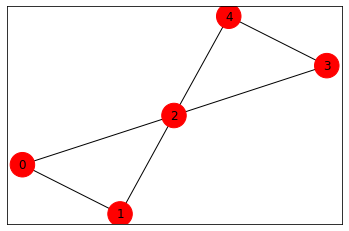

In [2]:
# Generating 5 training examples
n = 5
V = np.arange(0,n,1)
E =[(0,1,1.0),(0,2,1.0),(1,2,1.0),(3,2,1.0),(3,4,1.0),(4,2,1.0)] 

G = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)

# Generate plot of the Graph
colors       = ['r' for node in G.nodes()]
default_axes = plt.axes(frameon=True)
pos          = nx.spring_layout(G)

nx.draw_networkx(G, node_color=colors, node_size=600, alpha=1, ax=default_axes, pos=pos)


<ipython-input-3-a3c1885f862b>:19: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax  = fig.gca(projection='3d')


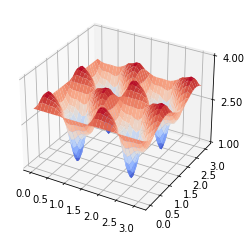


 --- OPTIMAL PARAMETERS --- 

The maximal expectation value is:  M1 = 3.431
This is attained for gamma = 1.900 and beta = 0.200


In [3]:
# Evaluate the function
step_size   = 0.1;

a_gamma         = np.arange(0, np.pi, step_size)
a_beta          = np.arange(0, np.pi, step_size)
a_gamma, a_beta = np.meshgrid(a_gamma,a_beta)

F1 = 3-(np.sin(2*a_beta)**2*np.sin(2*a_gamma)**2-0.5*np.sin(4*a_beta)*np.sin(4*a_gamma))*(1+np.cos(4*a_gamma)**2)

# Grid search for the minimizing variables
result = np.where(F1 == np.amax(F1))
a      = list(zip(result[0],result[1]))[0]

gamma  = a[0]*step_size;
beta   = a[1]*step_size;

# Plot the expetation value F1
fig = plt.figure()
ax  = fig.gca(projection='3d')

surf = ax.plot_surface(a_gamma, a_beta, F1, cmap=cm.coolwarm, linewidth=0, antialiased=True)

ax.set_zlim(1,4)
ax.zaxis.set_major_locator(LinearLocator(3))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

plt.show()

#The smallest parameters and the expectation can be extracted
print('\n --- OPTIMAL PARAMETERS --- \n')
print('The maximal expectation value is:  M1 = %.03f' % np.amax(F1))
print('This is attained for gamma = %.03f and beta = %.03f' % (gamma,beta))
